In [1]:
from google.cloud import storage
import os
import tensorflow as tf
import math
import numpy as np
import itertools
from PIL import Image
from tensorflow import image

tf.enable_eager_execution()
from yolo3.model import preprocess_true_boxes
## if it is private gcs use storage.Client().fromservice account insted of storage.Client()

Using TensorFlow backend.


## Reading tfrecords from google cloud storage 

In [2]:
def list_blobs_with_prefix(bucket_name, prefix, delimiter=None):
    
    storage_client = storage.Client()
    bucket = storage_client.get_bucket(bucket_name)

    blobs = bucket.list_blobs(prefix=prefix, delimiter=delimiter)
    file_list = []
    for blob in blobs:
        file_list.append('gs://'+bucket_name+'/'+blob.name)

    return file_list


In [26]:

def get_random_data(image, input_shape, x_min, y_min, x_max, y_max,label ,random=False, max_boxes=20, jitter=.3, hue=.1, sat=1.5, val=1.5, proc_img=True):
    '''random preprocessing for real-time data augmentation'''
    #line = annotation_line.split()
    image = Image.fromarray(image.numpy())
    iw, ih = (1920,1280)
    h, w = input_shape
    box = np.array([np.array(list(map(int,box.split(',')))) for box in line[1:]])
    box = []
    for x1,y1,x2,y2,l in zip(x_min, y_min, x_max, y_max, label):
        box.append(np.array([x1, y1, x2, y2, l]))
        
    box = np.array(box)
    
    
    if not random:
        # resize image
        scale = min(w/iw, h/ih)
        nw = int(iw*scale)
        nh = int(ih*scale)
        dx = (w-nw)//2
        dy = (h-nh)//2
        #image_data=0
        if proc_img:
        #tf.image.resize_images(x, size=[nw,nh], method=image.ResizeMethod.BICUBIC)
             image = image.resize((nw,nh), Image.BICUBIC)
             new_image = Image.new('RGB', (w,h), (128,128,128))
             new_image.paste(image, (dx, dy))
             image_data = np.array(new_image)/255.

        # correct boxes
        box_data = np.zeros((max_boxes,5))
        if len(box)>0:
            np.random.shuffle(box)
            if len(box)>max_boxes: box = box[:max_boxes]
            box[:, [0,2]] = box[:, [0,2]]*scale + dx
            box[:, [1,3]] = box[:, [1,3]]*scale + dy
            box_data[:len(box)] = box

        return image_data, box_data

    # resize image
    new_ar = w / h * rand(1 - jitter, 1 + jitter) / rand(1 - jitter, 1 + jitter)
    scale = rand(.25, 2)
    if new_ar < 1:
        nh = int(scale * h)
        nw = int(nh * new_ar)
    else:
        nw = int(scale * w)
        nh = int(nw / new_ar)
    image = image.resize((nw, nh), Image.BICUBIC)
    #image = 0
    # place image
    dx = int(rand(0, w - nw))
    dy = int(rand(0, h - nh))
    new_image = Image.new('RGB', (w, h), (128, 128, 128))
    new_image.paste(image, (dx, dy))
    image = new_image

    flip = rand()<.5
    if flip: image = image.transpose(Image.FLIP_LEFT_RIGHT)

    # distort image
    hue = rand(-hue, hue)
    sat = rand(1, sat) if rand()<.5 else 1/rand(1, sat)
    val = rand(1, val) if rand()<.5 else 1/rand(1, val)
    x = rgb_to_hsv(np.array(image)/255.)
    x[..., 0] += hue
    x[..., 0][x[..., 0]>1] -= 1
    x[..., 0][x[..., 0]<0] += 1
    x[..., 1] *= sat
    x[..., 2] *= val
    x[x>1] = 1
    x[x<0] = 0
    image_data = hsv_to_rgb(x) # numpy array, 0 to 1

    # correct boxes
    box_data = np.zeros((max_boxes,5))
    if len(box)>0:
        np.random.shuffle(box)
        box[:, [0,2]] = box[:, [0,2]]*nw/iw + dx
        box[:, [1,3]] = box[:, [1,3]]*nh/ih + dy
        if flip: box[:, [0,2]] = w - box[:, [2,0]]
        box[:, 0:2][box[:, 0:2]<0] = 0
        box[:, 2][box[:, 2]>w] = w
        box[:, 3][box[:, 3]>h] = h
        box_w = box[:, 2] - box[:, 0]
        box_h = box[:, 3] - box[:, 1]
        box = box[np.logical_and(box_w>1, box_h>1)] # discard invalid box
        if len(box)>max_boxes: box = box[:max_boxes]
        box_data[:len(box)] = box
    #image_data = 
    return image_data, box_data

In [24]:
def _parse_function(proto):
    # define your tfrecord again. Remember that you saved your image as a string.
    image_feature_description={
      'image/filename': tf.io.VarLenFeature(tf.string),
      'image/format': tf.io.FixedLenFeature([],tf.string),
      'image/encoded': tf.io.FixedLenFeature([],tf.string),
      'image/object/bbox/center_x': tf.io.VarLenFeature(tf.float32),
      'image/object/bbox/center_y': tf.io.VarLenFeature(tf.float32),
      'image/object/bbox/width': tf.io.VarLenFeature(tf.float32),
      'image/object/bbox/height': tf.io.VarLenFeature(tf.float32),
      'image/object/class/text': tf.io.VarLenFeature(tf.string),
      'image/object/class/label': tf.io.VarLenFeature(tf.int64),
  }
    # Load one example
    parsed_features = tf.parse_single_example(proto, image_feature_description)
    x_min = parsed_features['image/object/bbox/center_x'].values - 0.5*parsed_features['image/object/bbox/width'].values
    y_min = parsed_features['image/object/bbox/center_y'].values - 0.5*parsed_features['image/object/bbox/height'].values
    x_max = parsed_features['image/object/bbox/center_x'].values + 0.5*parsed_features['image/object/bbox/width'].values
    y_max = parsed_features['image/object/bbox/center_y'].values + 0.5*parsed_features['image/object/bbox/height'].values
    # Turn your saved image string into an array
    # parsed_features['image/encoded'] = tf.decode_raw(
    #     parsed_features['image/encoded'], tf.uint8)
    
    parsed_features['image/encoded'] = tf.io.decode_jpeg(parsed_features['image/encoded'])
    image, box = get_random_data(parsed_features['image/encoded'], input_shape, x_min, y_min, x_max, y_max,'image/object/class/label' ,random=True)
    
    ## modify this to return what data is needed
    return image, box

In [5]:
input_shape = (640,640)
def get_anchors(anchors_path):
    '''loads the anchors from a file'''
    with open(anchors_path) as f:
        anchors = f.readline()
    anchors = [float(x) for x in anchors.split(',')]
    return np.array(anchors).reshape(-1, 2)

def rand(a=0, b=1):
    return np.random.rand()*(b-a) + a

anchors_path = 'yolo_anchors_6.txt'
anchors = get_anchors(anchors_path)

In [6]:
def read_tfrecords(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    #dataset = ds_train
    # Maps the parser on every filepath in the array. You can set the number of parallel loaders here
    dataset = dataset.map(_parse_function, num_parallel_calls=8)
    dataset = dataset.map(lambda x, y: (x,preprocess_true_boxes(y, input_shape, anchors, 2)))
    # This dataset will go on forever
    dataset = dataset.repeat()

    # Set the number of datapoints you want to load and shuffle 
    dataset = dataset.shuffle(3)

    # Set the batchsize
    dataset = dataset.batch(1)

    # Create an iterator
    iterator = dataset.make_one_shot_iterator()

    # Create your tf representation of the iterator
    image, label = iterator.get_next()
    # Bring your picture back in shape
    return image, label

In [ ]:
#get tf records list from gcs
validation_filenames = list_blobs_with_prefix('waymo_validation','validation_dataset/tf_records')
#images,labels = read_tfrecords(validation_filenames)
x,y = read_tfrecords(validation_filenames[0])


In [33]:
img = Image.fromarray(x.numpy())
w = 640
h = 640
ih, iw = (1280, 1920)
scale = min(w/iw, h/ih)
nw = int(iw*scale)
nh = int(ih*scale)
dx = (w-nw)//2
dy = (h-nh)//2

## uplaod a local file to gcs

In [18]:
def upload_blob(bucket_name, source_file_name, destination_blob_name):
    """Uploads a file to the bucket."""
    storage_client = storage.Client()
    bucket = storage_client.get_bucket(bucket_name)
    blob = bucket.blob(destination_blob_name)

    blob.upload_from_filename(source_file_name)
    print('File {} uploaded to {}.'.format(
        source_file_name,
        destination_blob_name))

In [20]:
upload_blob('waymo_validation','xyz.png','abc/xsx')

File xyz.png uploaded to abc/xsx.


## uplaod a local variable or data in variable to gcs

In [24]:
def upload_blob_from_bytes(bucket_name, source_file_name, destination_blob_name):
    """Uploads a file to the bucket."""
    storage_client = storage.Client()
    bucket = storage_client.get_bucket(bucket_name)
    blob = bucket.blob(destination_blob_name)

    blob.upload_from_string(source_file_name,content_type='image/png')
    #blob.upload_blob
    print('File {} uploaded to {}.'.format(
        source_file_name,
        destination_blob_name))

In [29]:
def download_blob2(bucket_name, destination_blob_name):
    """download a file to the bucket."""
    storage_client = storage.Client()
    bucket = storage_client.get_bucket(bucket_name)
    blob = bucket.blob(destination_blob_name)

    file_string = blob.download_as_string()
    return file_string

In [15]:
image_feature_description={
          'image/filename': tf.io.VarLenFeature(tf.string),
      'image/format': tf.io.FixedLenFeature([],tf.string),
      'image/encoded': tf.io.FixedLenFeature([],tf.string),
      'image/object/bbox/center_x': tf.io.VarLenFeature(tf.float32),
      'image/object/bbox/center_y': tf.io.VarLenFeature(tf.float32),
      'image/object/bbox/width': tf.io.VarLenFeature(tf.float32),
      'image/object/bbox/height': tf.io.VarLenFeature(tf.float32),
      'image/object/class/text': tf.io.VarLenFeature(tf.string),
      'image/object/class/label': tf.io.VarLenFeature(tf.int64),
  }
    # Load one example
#parsed_features = tf.parse_single_example(proto, image_feature_description)

In [17]:
validation_filenames = list_blobs_with_prefix('waymo_validation','validation_dataset/tf_records')
dataset = tf.data.TFRecordDataset(validation_filenames[0], compression_type='')
for data in dataset:
    parsed_data = tf.parse_single_example(data, image_feature_description)
    break

In [28]:
parsed_data['image/object/bbox/center_y'].values.numpy() - parsed_data['image/object/bbox/center_x'].values.numpy()

array([-294.32098, -425.06012,  296.84732, -320.21613, -587.3787 ,
       -661.84814,  351.16406, -374.5329 ], dtype=float32)

In [32]:
file_name = 'Training_data/images/waymo_vtraining_front_1.jpg'
file_string = download_blob2('waymo_validation',file_name)
iw, ih = (1920,1280)



In [41]:
image = Image.frombytes('RGB', (ih, ih), file_string)

ValueError: not enough image data

In [35]:
f =open('test.jpg','wb')
f.write(file_string)
f.close()

In [36]:
image = Image.open('test.jpg')


In [48]:
img = Image.open(io.BytesIO(file_string))

In [43]:
import StringIO


ImportError: No module named 'StringIO'

In [45]:
!pip3 install StringIO --user

ERROR: Could not find a version that satisfies the requirement StringIO (from versions: none)
ERROR: No matching distribution found for StringIO


In [46]:
import io


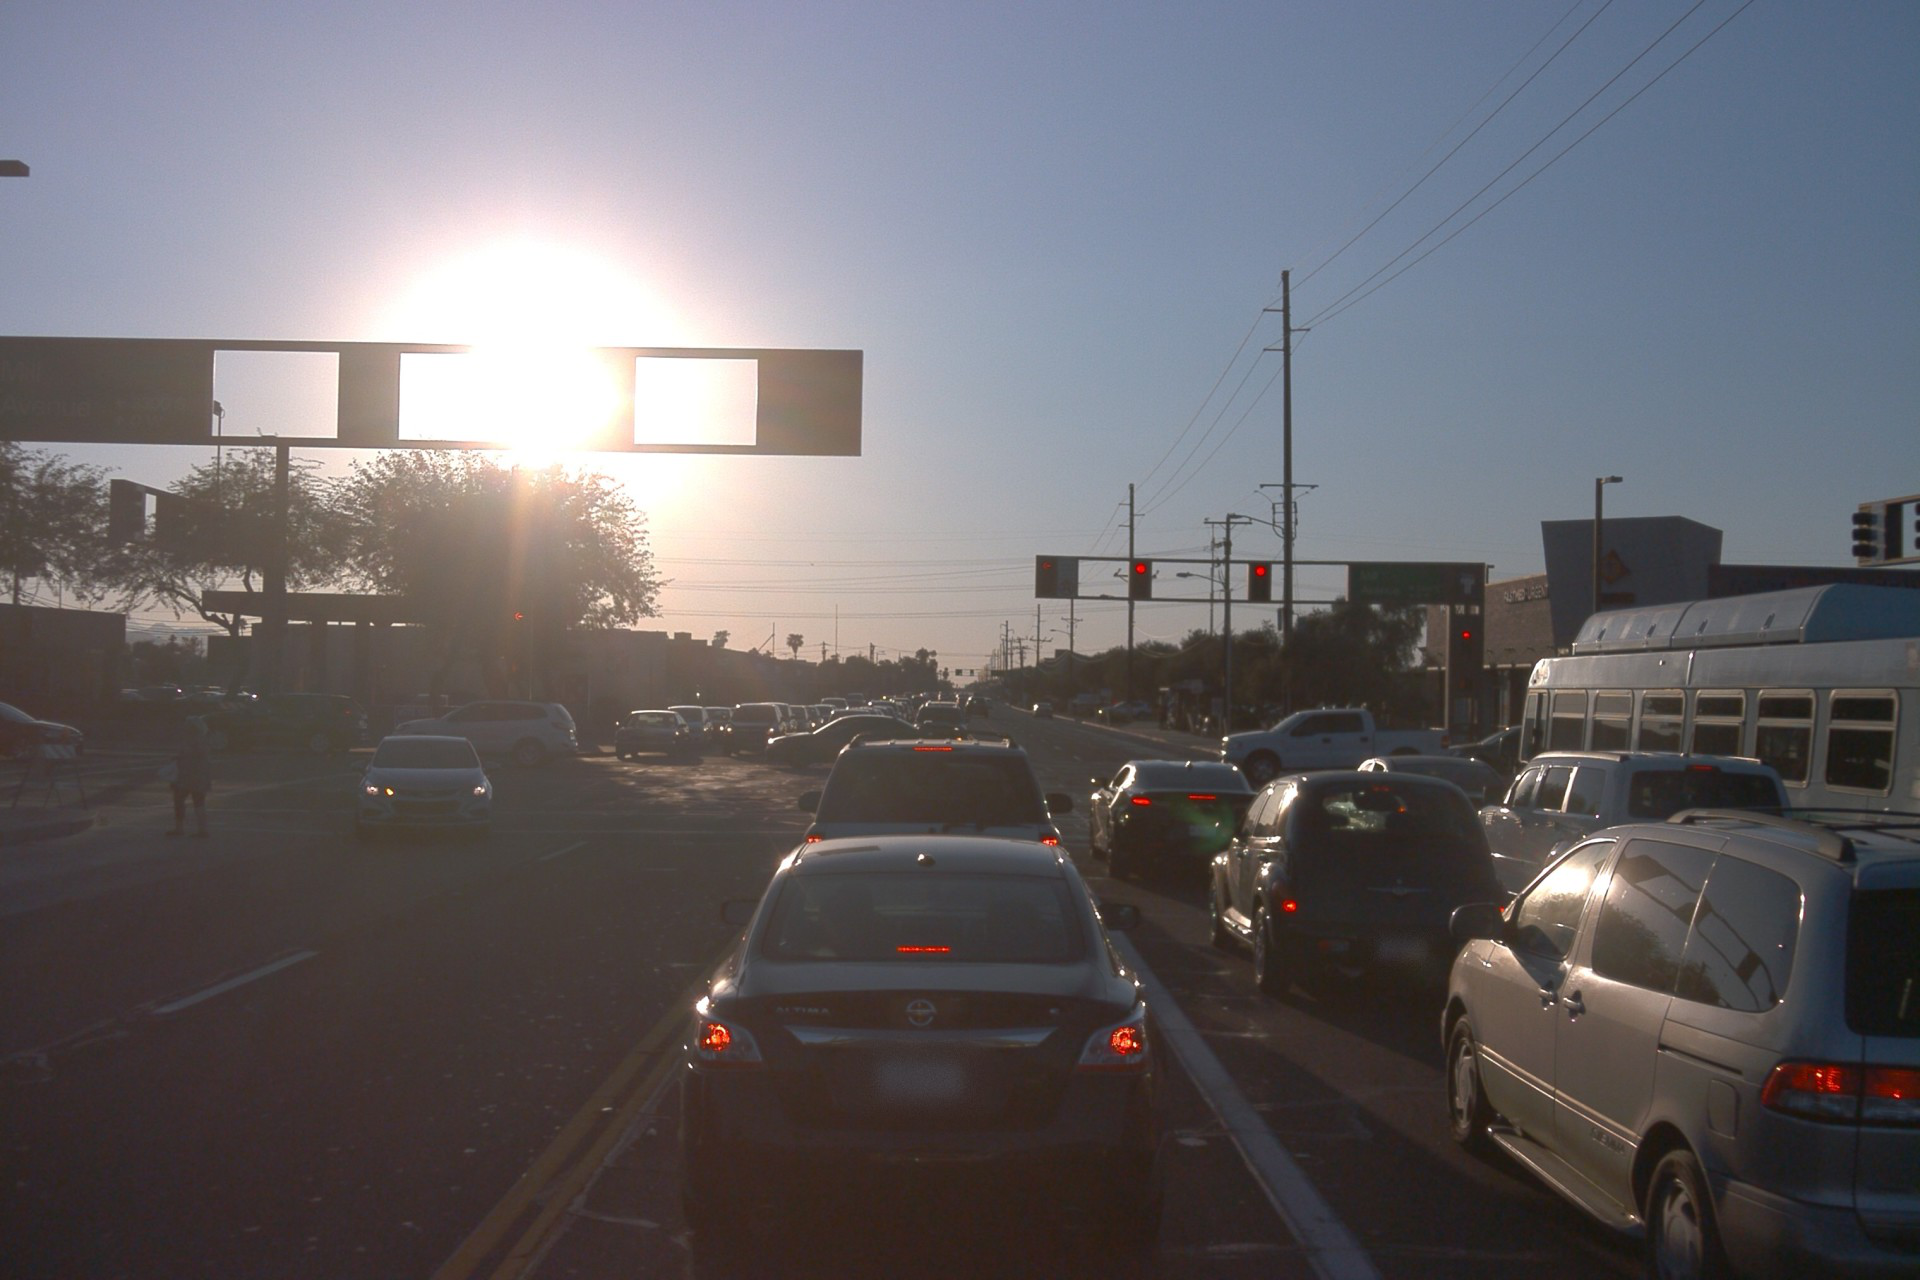

In [49]:
img